In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import numpy as np
import pyross
import pandas as pd
import time 
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [3]:
## population and age classes
M=4  ## number of age classes

my_data = np.genfromtxt('../data/age_structures/UK.csv', delimiter=',', skip_header=1)
aM, aF = my_data[:, 1], my_data[:, 2]

Ni0=aM+aF;   Ni=np.zeros((M))

# scale the population down to a more manageble level 
s=1e3
Ni[0] = (np.sum(Ni0[0:4])/s).astype('int')
Ni[1] = (np.sum(Ni0[4:8])/s).astype('int')
Ni[2] = (np.sum(Ni0[8:12])/s).astype('int')
Ni[3] = (np.sum(Ni0[12:16])/s).astype('int')
N=np.sum(Ni)
fi = Ni/N 

# Get individual contact matrices
CH0, CW0, CS0, CO0 = pyross.contactMatrix.UK()


CH = np.zeros((M, M))
CW = np.zeros((M, M))
CS = np.zeros((M, M))
CO = np.zeros((M, M))


for i in range(M):
    for j in range(M):
        i1, j1 = i*4, j*4
        CH[i,j] = np.sum( CH0[i1:i1+4,j1:j1+4]*Ni0[i1:i1+4] )/Ni[i]
        CW[i,j] = np.sum( CW0[i1:i1+4,j1:j1+4]*Ni0[i1:i1+4] )/Ni[i]
        CS[i,j] = np.sum( CS0[i1:i1+4,j1:j1+4]*Ni0[i1:i1+4] )/Ni[i]
        CO[i,j] = np.sum( CO0[i1:i1+4,j1:j1+4]*Ni0[i1:i1+4] )/Ni[i]

In [4]:
# Generate class with contact matrix for SIR model with UK contact structure
generator = pyross.contactMatrix.SIR(CH, CW, CS, CO) #same for any model

times= [20] # temporal boundaries between different contact-behaviour

aW, aS, aO = 0.7, 0.6, 0.5

# prefactors for CW, CS, CO:
interventions = [[1.0,1.0,1.0],      # before first time
                 [aW, aS, aO],       # after first time
                ]         

# generate corresponding contact matrix function
C = generator.interventions_temporal(times=times,interventions=interventions)

In [5]:
beta  = 0.000454      # contact rate parameter
gE    = 1./70          #rate of exposed -> infected
gIa   = 1./70            # recovery rate of asymptomatic infectives 
gIs   = 1./70            # recovery rate of symptomatic infectives 
alpha = 0.2              # asymptomatic fraction
fsa   = 0.8               # suppresion of contact by symptomatics

 #initial conditions
E_0 = np.ones(M)*100
Is_0 = np.ones(M)*100
Is_0[1] += 100 #make one group different 
Ia_0 = np.zeros((M))*20
Ia_0[1] += 50
R_0  = np.zeros((M))
S_0  = Ni - (Ia_0 + E_0+ Is_0 + R_0)


parameters = {'alpha':alpha,'beta':beta,'gE':gE, 'gIa':gIa,'gIs':gIs,'fsa':fsa}
model = pyross.stochastic.SEIR(parameters, M, Ni)
# model = pyross.deterministic.SIR(parameters, M, Ni)

contactMatrix=C

# start simulation
Tf=80;  Nf=Tf+1 
data=model.simulate(S_0, E_0,Ia_0, Is_0, contactMatrix, Tf, Nf)
np.save('cal_lat_SEIR_traj.npy', data['X'])

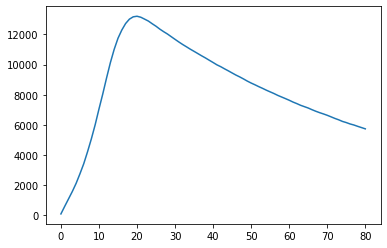

In [6]:
IC  = np.zeros((Nf))
for i in range(M):
        IC += data['X'][:,2*M+i] 
t = data['t']
# plt.plot(t, data['X'][:,1*M] )
plt.plot(t, data['X'][:,1*M])
plt.show() 

### Compare the deterministic trajectory and the stochastic one before intervention

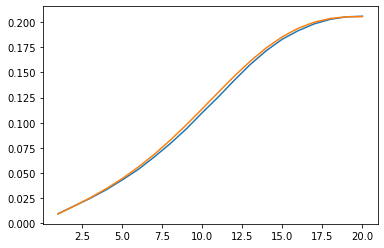

In [7]:
Tf_initial = 20 # truncate to only getting the first few datapoints 
Nf_initial = Tf_initial+1

x = np.load('cal_lat_SEIR_traj.npy')
x = (x/N)[:Nf_initial]
steps = 101 # number internal integration steps taken

fltr=np.repeat(np.array([False,False, False, True]), M)
obs=x[:, fltr] 
contactMatrix = generator.constant_contactMatrix()
det_model = pyross.deterministic.SEIR(parameters, int(M), fi)
estimator = pyross.inference.SEIR(parameters, M, fi, int(N), steps)
xm,full_cov = estimator.obtain_full_mean_cov(x[0], Tf_initial, Nf_initial, det_model, contactMatrix)
t = np.linspace(1, Tf_initial, Nf_initial-1)
# xm = estimator.integrate(x[0], Tf_initial, Nf_initial, 20, det_model, contactMatrix)
plt.plot(t, x[1:,1*M])
# plt.plot(t, data['X'][:,2*M+i][1:Nf_initial])
plt.plot(t, xm[:,1*M])
plt.show()

In [8]:
# initialise the estimator 
estimator = pyross.inference.SEIR(parameters, M, fi, int(N), steps)

# compute -log_p for the original (correct) parameters 
start_time = time.time() 
parameters = {'alpha':alpha, 'beta':beta,'gE':gE, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
logp = estimator.minus_logp_red(parameters, x[0], obs[1:], fltr, Tf_initial, Nf_initial, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

-603.9469120418273
1.6082992553710938


In [ ]:
# take a guess 
beta_g = 0.0005
gE_g = 1./72
gIa_g = 1./68
gIs_g = 1./65
alpha_g = 0.25
guess = np.array([alpha_g, beta_g, gE_g, gIa_g, gIs_g])

eps = 1e-3 # step used to calculate hessian in the optimisation algorithm 

alpha_g = 0.25
alpha_bounds = (eps, 1)
# the bound for alpha must be 1-2*eps to avoid alpha>1 in hessian calculation performed by optimizer 

beta_g = 0.005
beta_bounds = (0, 1)

gE_g = 1./700
gE_bounds = (eps, 1)

gIa_g = 1./700
gIa_bounds = (eps, 1)

gIs_g = 1./700
gIs_bounds = (eps, 1) 

fsa_g = 0.8

Is0_g = (Is_0+10)/N 
bounds_for_Is = [(1/N, 120/N)]*M 
bounds_for_Is[1] = (180/N, 220/N)

Ia0_g = (Ia_0+10)/N
bounds_for_Ia = [(1/N, 100/N)]*M

E0_g = (E_0)/N
bounds_for_E0 = [(1/N, 500/N)]*M

S0_g = S_0/N
bounds_for_S = [(fi[i]-400/N, fi[i]-bounds_for_Is[i][0]/N) for i in range(M)]


# optimisation parameters 
ftol = 1e-4 # the relative tol in (-logp)  
bounds = np.array([alpha_bounds, beta_bounds, gE_bounds, gIa_bounds, gIs_bounds, 
                   *bounds_for_S, *bounds_for_E0, *bounds_for_Ia, *bounds_for_Is])
# print(bounds, "\n",guess)

guess = np.array([alpha_g, beta_g, gE_g, gIa_g, gIs_g, *S0_g, *E0_g, *Ia0_g, *Is0_g])
# print([bounds[i,0]<guess[i]<bounds[i,1] for i in range(len(guess))])
params = estimator.latent_inference(guess, .1*np.ones(guess.shape),obs, fltr, Tf_initial, Nf_initial, contactMatrix,
                                    bounds, beta_rescale=1, verbose=True, niter=2, ftol=ftol, eps=eps,
                                    global_max_iter=15, local_max_iter=15)
# the L-BFGS-B method prints to the terminal rather than here 

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 21 (seed=427372, Fri May  1 14:53:28 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 2.910219719848270e+02 1.0e+00 9.22e-01  3e-02  3e-02 0:32.3
    2     32 -1.272436660855703e+02 1.1e+00 8.63e-01  3e-02  3e-02 1:02.5
    3     48 2.535696794407148e+02 1.1e+00 8.16e-01  3e-02  3e-02 1:34.5


In [ ]:
# save the parameters 
np.save('SEIR_cal_lat_param.npy', params)

In [ ]:
# check the predictions 
params = np.load('SEIR_cal_lat_param.npy')
x = np.load('cal_lat_SEIR_traj.npy')/N
parameters = {'alpha':params[0], 'beta':params[1], 'gE':params[2],
              'gIa':params[3], 'gIs':params[4],'fsa':0.8}

estimator.set_params(parameters)
x0 = params[len(parameters)-1:]
det_model = pyross.deterministic.SEIR(parameters, M, fi)
contactMatrix = generator.constant_contactMatrix()
x_det = estimator.integrate(x0, 0, Tf_initial, Nf_initial, det_model, contactMatrix)
plt.plot(x[:Nf_initial,1*M], label='Ia')
plt.plot(x_det[:, 1*M])
plt.plot(x[:Nf_initial,2*M], label='Is')
plt.plot(x_det[:, 2*M])
plt.legend()
plt.show()

In [ ]:
aW_g = 0.6 
aW_bounds = [0.2, 0.8]
aS_g = 0.6
aS_bounds = [0.2, 0.8]
aO_g = 0.6
aO_bounds = [0.2, 0.8]
guess = np.array([aW_g, aS_g, aO_g])
bounds = np.array([aW_bounds, aS_bounds, aO_bounds])

x = np.load('cal_lat_SEIR_traj.npy')/N
x = x[Nf_initial:]
obs = x[:, fltr]
Nf_control = x.shape[0] 
Tf_control = Nf_control-1 

det_model = pyross.deterministic.SEIR(parameters, M, fi)
contactMatrix = generator.constant_contactMatrix()
x0 = estimator.integrate(params[-4*M:], 0, Tf_initial, 2, det_model, contactMatrix)[-1]
x0 = np.array(x0)
times = [Tf+1]
interventions = [[aW, aS, aO]]
contactMatrix = generator.interventions_temporal(times=times,interventions=interventions)

# compute -log_p for the initial guess (for the moment, use correct parameters)
parameters = estimator.make_params_dict(params)
logp = estimator.minus_logp_red(parameters, x0, obs[1:], fltr, Tf_control, Nf_control, contactMatrix)
print(logp) 

In [ ]:
eps = 1e-3 
start_time = time.time() 

parameters = estimator.make_params_dict(params)
estimator.set_params(parameters) 
control_params = estimator.latent_infer_control(guess,.1*np.ones(guess.shape), x0, obs, fltr, Tf_control, Nf_control, generator, bounds,
                                  niter=2, eps=eps, verbose=True, global_max_iter=15)
end_time = time.time()
print(control_params) # best guess 
print(end_time - start_time)

In [ ]:
times = [20]
interventions = [[1.0,1.0,1.0],      # before first time
                 control_params,       # after first time
                ]         

# compare the true trajectory with the 
contactMatrix = generator.interventions_temporal(times=times,interventions=interventions)
det_model = pyross.deterministic.SEIR(parameters, M, fi)
x0 = params[len(parameters)-1:]
x_det = estimator.integrate(x0, 0, Tf, Nf, det_model, contactMatrix)
x = np.load('cal_lat_SEIR_traj.npy')/N
plt.plot(x[:,1*M], label='Ia')
plt.plot(x_det[:, 1*M])
plt.plot(x[:,2*M], label='Is')
plt.plot(x_det[:, 2*M])
plt.legend()
plt.show()
print(x.shape)